In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Windows용 한글 폰트 지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 정상 표시 (음수 깨짐 방지)

plt.rcParams['axes.unicode_minus'] = False


In [3]:
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
sellers_df = pd.read_csv('data/olist_sellers_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
products_df = pd.read_csv('data/olist_products_dataset.csv')
geolocation_df = pd.read_csv('data/olist_geolocation_dataset.csv')
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
order_reviews_df = pd.read_csv('data/olist_order_reviews_dataset.csv')
categories_df = pd.read_csv('data/product_category_name_translation.csv')

재구매 고객 수: 2997명
재구매 고객 주문 수: 6342건


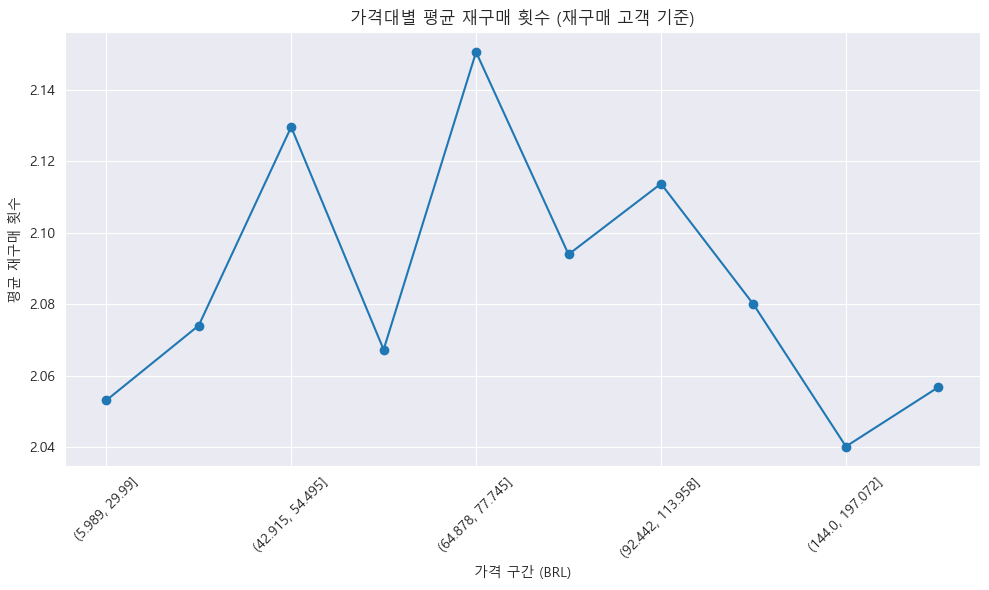

In [4]:
#  customer_unique_id 결합
orders_df = orders_df.merge(customers_df[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

#  고객별 주문 수 계산
order_counts = orders_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_counts.columns = ['customer_unique_id', 'order_count']

#  2회 이상 구매한 고객 필터링
repeat_customers = order_counts[order_counts['order_count'] >= 2]
print(f"재구매 고객 수: {len(repeat_customers)}명")

#  재구매 고객의 주문만 필터링
repeat_orders = orders_df[orders_df['customer_unique_id'].isin(repeat_customers['customer_unique_id'])]
print(f"재구매 고객 주문 수: {len(repeat_orders)}건")

#  주문별 가격 정보 결합
merged = pd.merge(repeat_orders, order_items_df, on='order_id', how='inner')

#  고객별 재구매 횟수, 평균 가격 계산
cust_summary = merged.groupby('customer_unique_id').agg(
    purchase_count=('order_id', 'nunique'),
    avg_price=('price', 'mean')
).reset_index()

#  가격 구간 나누기
cust_summary['price_bin'] = pd.qcut(cust_summary['avg_price'], 10, duplicates='drop')

#  가격 구간별 평균 재구매 횟수
avg_purchase_by_price_bin = cust_summary.groupby('price_bin', observed=True)['purchase_count'].mean()

# . 시각화
plt.figure(figsize=(10,6))
avg_purchase_by_price_bin.plot(marker='o')
plt.title('가격대별 평균 재구매 횟수 (재구매 고객 기준)')
plt.xlabel('가격 구간 (BRL)')
plt.ylabel('평균 재구매 횟수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


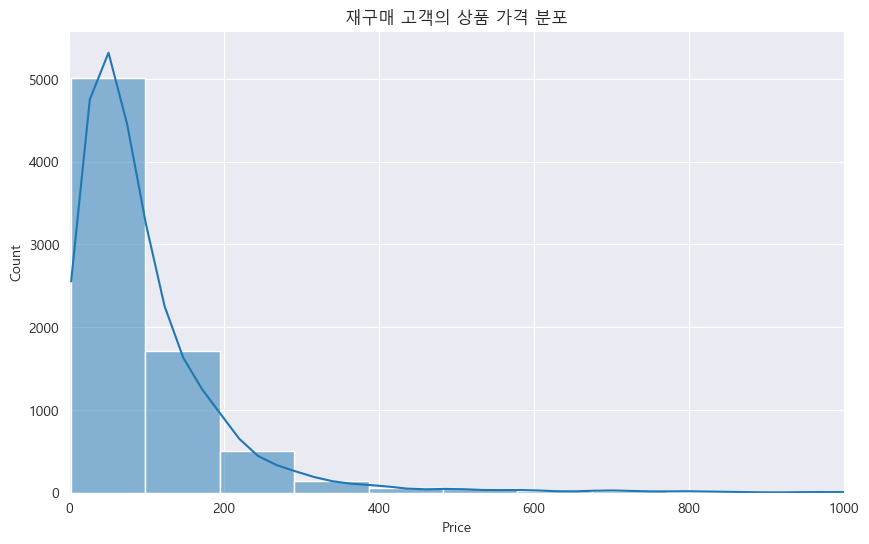

In [5]:

plt.figure(figsize=(10, 6))
sns.histplot(merged['price'], bins=50, kde=True)
plt.title('재구매 고객의 상품 가격 분포')
plt.xlabel('Price')
plt.xlim(0,1000)
plt.ylabel('Count')
plt.grid(True)
plt.show()
#역시 100~ 200이 제일 많았음


In [6]:
print(merged['price'].describe())
#평균가격 102 인것에 비해  max가 4800수준


count    7568.000000
mean      102.909880
std       144.801442
min         2.900000
25%        37.900000
50%        69.900000
75%       120.000000
max      4799.000000
Name: price, dtype: float64


C:\Users\Playdata2\AppData\Local\Temp\ipykernel_8048\2675441663.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_purchase_by_price_bin = cust_summary.groupby('price_bin')['purchase_count'].mean()


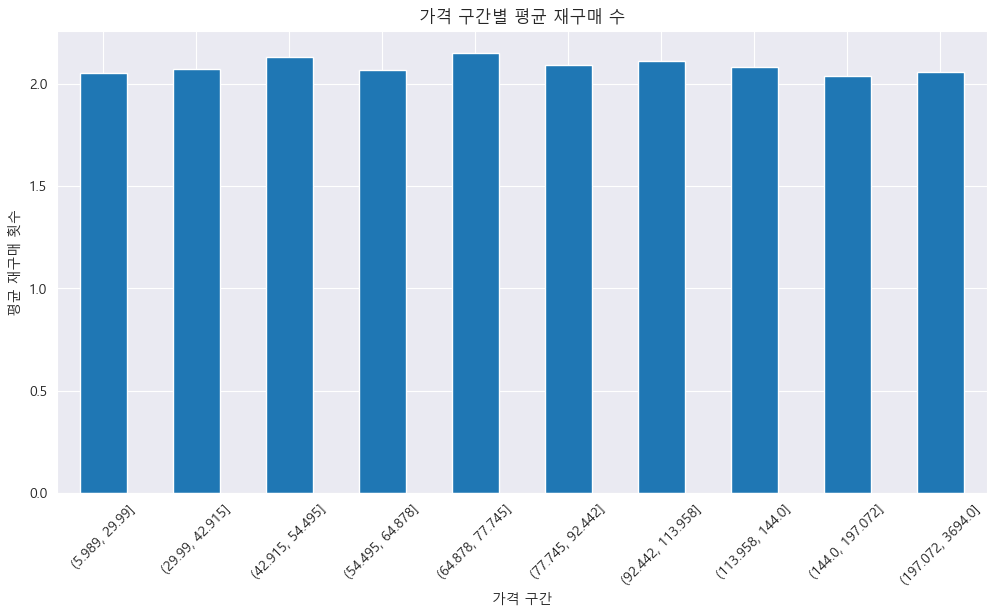

In [7]:
 # 고객별 평균 가격 및 구매 수 계산
cust_summary = merged.groupby('customer_unique_id').agg({
    'price': 'mean',
    'order_id': 'nunique'
}).rename(columns={'order_id': 'purchase_count'}).reset_index()

# 가격을 10구간으로 나눔
cust_summary['price_bin'] = pd.qcut(cust_summary['price'], 10)

# 가격 구간별 평균 구매 수 시각화
avg_purchase_by_price_bin = cust_summary.groupby('price_bin')['purchase_count'].mean()

plt.figure(figsize=(12,6))
avg_purchase_by_price_bin.plot(kind='bar')
plt.title('가격 구간별 평균 재구매 수')
plt.ylabel('평균 재구매 횟수')
plt.xlabel('가격 구간')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# 거의 골고르 2번씩 삼 ㄷㄷ


In [8]:
# 배송 시간 계산
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])
merged['order_delivered_customer_date'] = pd.to_datetime(merged['order_delivered_customer_date'])
merged['shipping_time'] = (merged['order_delivered_customer_date'] - merged['order_purchase_timestamp']).dt.days

# 상관관계 분석
corr_df = merged[['price', 'freight_value', 'shipping_time']].dropna()
print(corr_df.corr())
# 가격과 운송료 0.3 -> 중간상관관계

                  price  freight_value  shipping_time
price          1.000000       0.379323       0.048920
freight_value  0.379323       1.000000       0.243608
shipping_time  0.048920       0.243608       1.000000


In [9]:
high_price_cust = cust_summary[cust_summary['price'] > cust_summary['price'].median()]
low_price_cust = cust_summary[cust_summary['price'] <= cust_summary['price'].median()]

print("고가 고객 평균 재구매 횟수:", high_price_cust['purchase_count'].mean())
print("저가 고객 평균 재구매 횟수:", low_price_cust['purchase_count'].mean())


고가 고객 평균 재구매 횟수: 2.0769745649263722
저가 고객 평균 재구매 횟수: 2.0949832775919734


# 재구매 고객 정의 및 주문 필터링

In [11]:
# customer_unique_id 결합
orders_df = orders_df.merge(customers_df[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

# 고객별 주문 수 계산
order_counts = orders_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
# 언유니크하면 컬럼이 바뀐값이 반환되니까 리셋인덱스를 해주는겨

order_counts.columns = ['customer_unique_id', 'order_count']

# 2회 이상 구매 고객 추출
repeat_customers = order_counts[order_counts['order_count'] >= 2]

# 재구매 고객 주문 필터링
repeat_orders = orders_df[orders_df['customer_unique_id'].isin(repeat_customers['customer_unique_id'])]


In [12]:
repeat_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id_x,customer_unique_id_y,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,7c396fd4830fd04220f754e42b4e5bff,7c396fd4830fd04220f754e42b4e5bff
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,ccafc1c3f270410521c3c6f3b249870f,ccafc1c3f270410521c3c6f3b249870f,ccafc1c3f270410521c3c6f3b249870f
16,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06 00:00:00,6e26bbeaa107ec34112c64e1ee31c0f5,6e26bbeaa107ec34112c64e1ee31c0f5,6e26bbeaa107ec34112c64e1ee31c0f5
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,08fb46d35bb3ab4037202c23592d1259,08fb46d35bb3ab4037202c23592d1259,08fb46d35bb3ab4037202c23592d1259
46,d17dc4a904426827ca80f2ccb3a6be56,569cf68214806a39acc0f39344aea67f,delivered,2017-05-14 20:28:25,2017-05-14 20:42:45,2017-05-16 08:17:46,2017-05-25 09:14:31,2017-06-12 00:00:00,c2551ea089b7ebbc67a2ea8757152514,c2551ea089b7ebbc67a2ea8757152514,c2551ea089b7ebbc67a2ea8757152514
...,...,...,...,...,...,...,...,...,...,...,...
99307,58edf3f5f282ab91e0f6a6f2b85af02a,14945bc802d49b0f9f68f2ea8fd060c4,delivered,2018-05-07 09:01:58,2018-05-08 04:34:10,2018-05-10 12:35:00,2018-05-14 18:52:56,2018-05-30 00:00:00,62b8761192c86f4ead06f4a433096a2b,62b8761192c86f4ead06f4a433096a2b,62b8761192c86f4ead06f4a433096a2b
99344,bfecb4ee6ab98bff69307aab578db48a,e6f5f771cdbc5d09c994f16c9af6523d,delivered,2018-03-17 12:52:37,2018-03-17 13:10:35,2018-03-20 17:47:33,2018-03-27 19:16:57,2018-04-12 00:00:00,dca9a13536adcef18c6c5859487347b1,dca9a13536adcef18c6c5859487347b1,dca9a13536adcef18c6c5859487347b1
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,d05c44a138277ad325d915c6b7ccbcdf,d05c44a138277ad325d915c6b7ccbcdf,d05c44a138277ad325d915c6b7ccbcdf
99419,1b4a0e6b19d0034b531655b41ea89623,ce5efd1b1d8a2fa290a871edd5c26cd6,delivered,2017-10-02 08:45:35,2017-10-02 08:56:53,2017-10-03 20:26:19,2017-10-06 16:58:25,2017-10-24 00:00:00,39fff7cb5873a7116b02234bd1e6c6dc,39fff7cb5873a7116b02234bd1e6c6dc,39fff7cb5873a7116b02234bd1e6c6dc


In [13]:
# 날짜 타입으로 변환
repeat_orders['order_purchase_timestamp'] = pd.to_datetime(repeat_orders['order_purchase_timestamp'])

# 고객별 마지막 구매일 계산
last_purchase = repeat_orders.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
last_purchase.columns = ['customer_unique_id', 'last_purchase_date']


C:\Users\Playdata2\AppData\Local\Temp\ipykernel_8048\1431426189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repeat_orders['order_purchase_timestamp'] = pd.to_datetime(repeat_orders['order_purchase_timestamp'])


In [15]:
last_purchase

,customer_unique_id,last_purchase_date
0,00172711b30d52eea8b313a7f2cced02,2018-08-13 09:14:07
1,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54
2,004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48
3,0058f300f57d7b93c477a131a59b36c3,2018-03-22 18:09:41
4,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57
...,...,...
2992,ff36be26206fffe1eb37afd54c70e18b,2018-08-23 12:38:08
2993,ff44401d0d8f5b9c54a47374eb48c1b8,2017-05-19 21:20:54
2994,ff8892f7c26aa0446da53d01b18df463,2017-11-26 23:25:43
2995,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-09-14 14:24:04


In [35]:
# 전체 주문 중 가장 마지막 날짜 기준
reference_date = repeat_orders['order_purchase_timestamp'].max()

# 마지막 구매일로부터 경과일 계산
last_purchase['days_since_last_purchase'] = (reference_date - last_purchase['last_purchase_date']).dt.days

# 이탈 여부 정의: 90일 이상 경과 → 이탈
last_purchase['churn'] = last_purchase['days_since_last_purchase'] > 90

# 결과 확인
print("재구매 고객 수:", len(last_purchase))
print("이탈 고객 수:", last_purchase['churn'].sum())
print(last_purchase.head())


재구매 고객 수: 2997
이탈 고객 수: 2629
                 customer_unique_id  last_purchase_date  \
0  00172711b30d52eea8b313a7f2cced02 2018-08-13 09:14:07   
1  004288347e5e88a27ded2bb23747066c 2018-01-14 07:36:54   
2  004b45ec5c64187465168251cd1c9c2f 2018-05-26 19:42:48   
3  0058f300f57d7b93c477a131a59b36c3 2018-03-22 18:09:41   
4  00a39521eb40f7012db50455bf083460 2018-06-03 10:12:57   

   days_since_last_purchase  churn  
0                        64  False  
1                       275   True  
2                       143   True  
3                       208   True  
4                       135   True  
